# One Star Example

Demonstrates that
1) the independent tiling posterior approximation becomes increasingly bad as a star approaches a tile border
2) the checkerboard tiling posterior approximation remains reasonable regardless of star position

In [87]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import necessary packages and pick a GPU

In [88]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
from bliss.catalog import TileCatalog
from matplotlib import pyplot as plt
import numpy as np

Load the encoder with pre-trained weights. (This encoder was trained with 20% of tiles contain sources, which is quite high for one-star data, but the incorrect rate shouldn't detract from this example.)

In [89]:
from hydra import initialize, compose
from hydra.utils import instantiate

with initialize(config_path=".", version_base=None):
    cfg = compose("toy_example")

simulator = instantiate(cfg.simulator)

## Bright star

Create a batch synethic catalogs of one bright star at three positions: 0, 0.667, and 0.133 pixels from the border. (The first position is perfectly ambiguous, the second is somewhat ambiguous, the third is unambiguous.)

The nice thing about this setting is the lack of ambiguity in the (exact) posterior: there should be about one star detected. But is there with each of these posterior approximations?

In [90]:
def gen_loc_shift_data(pixel_shift, flux=10.0, add_galaxy=False):
    # 5.0 nmgy = 20.75 magnitude
    n = 100
    n_sources = torch.zeros(n, 20, 20, dtype=torch.long)
    n_sources[:, 10, 10] = 1

    locs = torch.ones(n, 20, 20, 1, 2) * 0.5
    locs[:, 10, 10, 0, 0] = pixel_shift * 0.25  # set this

    if add_galaxy:
        n_sources[:, 10, 9] = 1
    
    source_type = torch.zeros(n, 20, 20, 1, 1, dtype=torch.long)
    source_type[:, 10, 9] = 1

    galaxy_params = torch.ones(n, 20, 20, 1, 6) - 0.9
    galaxy_params[:, 10, 9, 0, 1] = 0.4
    galaxy_params[:, 10, 9, 0, [3,5]] = 10.0

    true_catalog_dict = {
        "n_sources": n_sources,
        "source_type": source_type,
        "locs": locs,
        "star_fluxes": torch.ones(n, 20, 20, 1, 5) * flux,  
        "galaxy_fluxes": torch.ones(n, 20, 20, 1, 5) * 40,
        "galaxy_params": galaxy_params,
    }
    true_catalog = TileCatalog(4, true_catalog_dict)

    rcfs, rcf_indices = simulator.randomized_image_ids(n)

    images, _, _, wcs_batch = simulator.image_decoder.render_images(true_catalog, rcfs)
    images = simulator.align_images(images, wcs_batch)
    background = simulator.background.sample(images.shape, image_id_indices=rcf_indices)
    images += background
    images = simulator.apply_noise(images)

    batch = {
        "images": images.cuda(),
        "background": background.cuda(),
        "tile_catalog": true_catalog.to("cuda"),
    }

    # one band
    batch["images"] = batch["images"][:, 2:3]
    batch["background"] = batch["background"][:, 2:3]
    batch["tile_catalog"]["star_fluxes"] = batch["tile_catalog"]["star_fluxes"][..., 2:3]
    batch["tile_catalog"]["galaxy_fluxes"] = batch["tile_catalog"]["galaxy_fluxes"][..., 2:3]

    return true_catalog, batch

Simulate one image for each catalog

Plot the r-band of sample images, one with each center

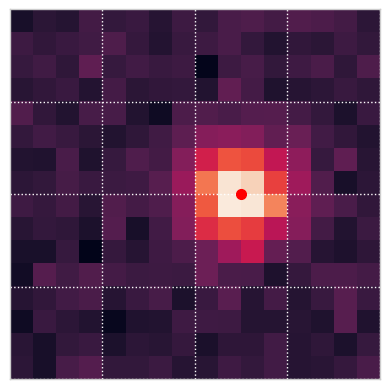

In [91]:
true_catalog, batch = gen_loc_shift_data(0.0)

i = 0
loc1 = (true_catalog["locs"][i, 10, 10, 0] + 10 - 8) * 4 - 0.5

plt.imshow(batch["images"][i, 0, 32:48, 32:48].cpu().numpy())
plt.grid(color='white', linewidth=1, linestyle='dotted')
plt.xticks(np.arange(4) * 4 + 3.5)
plt.yticks(np.arange(4) * 4 + 3.5)
plt.plot(loc1[1], loc1[0], 'ro', markersize=7)
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both', length=0)
plt.show()

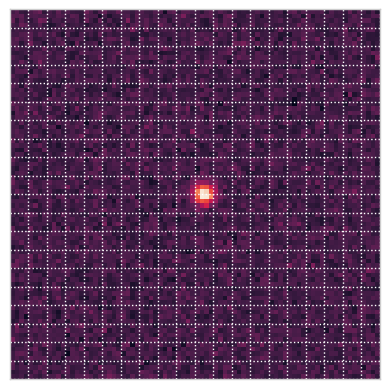

In [92]:
plt.imshow(batch["images"][i, 0].cpu().numpy())
plt.grid(color='white', linewidth=1, linestyle='dotted')
plt.xticks(np.arange(20) * 4 + 3.5);
plt.yticks(np.arange(20) * 4 + 3.5);
ax = plt.gca()
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.tick_params(axis='both', which='both', length=0);

Clear the GPU memory so we don't run out in case we re-run this notebook

In [93]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated() / 1e9  # show current memory usage in GB

0.148578304

In [129]:
torch.set_grad_enabled(False)

trainer = instantiate(cfg.train.trainer)
data_source = instantiate(cfg.train.data_source)
encoder = instantiate(cfg.encoder).cuda()
encoder.eval()

ckpt = "/home/regier/bliss_output/jul11_toyexample_oneband/version_0/checkpoints/best_encoder.ckpt"
state_dict = torch.load(ckpt)["state_dict"]
encoder.load_state_dict(state_dict)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<All keys matched successfully>

## test with validation image

In [150]:
file_datums = "/data/scratch/regier/20percent/dataset_0_size_4096.pt"
x = torch.load(file_datums)[0]

In [151]:
batch = {k: v[2:3].unsqueeze(0).cuda() for k, v in x.items() if k != "tile_catalog"}
d = {k: v.unsqueeze(0).cuda() for k, v in x["tile_catalog"].items()}
batch["tile_catalog"] = TileCatalog(4, d)

In [152]:
encoder.use_checkerboard = True
mode_cat, sample_cat = encoder.predict_step(batch, 0, 0).values()

In [154]:
(batch["tile_catalog"].on_fluxes > 10).sum()

tensor(81, device='cuda:0')

: 

### Checkerboard Tiling

Predict two catalogs: one the mode of the variational distribution and the other a sample of it

In [95]:
encoder.use_checkerboard = True
mode_cat, sample_cat = encoder.predict_step(batch, 0, 0).values()

Tthe source should be found in tile [10,10], moving in the first dimension
from 0 to 0.5. We restrict our attention to a 2 tiles per image to avoid spurious detections,
which are inevitable in a large enough image due to Gaussian noise.

For all three locations, all 20 replicates show 1 source in the variational distribution mode.

In [96]:
mode_cat["n_sources"][:, 9:11, 10].sum([1])

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')

In [108]:
mode_cat.on_fluxes[0, :, :, 0, 0]

tensor([[1.3322, 2.2456, 0.0000, 0.0000, 0.0000, 0.0000, 1.1026, 0.0000, 0.0000,
         1.2245, 0.0000, 1.3383, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.4748, 0.0000],
        [1.7751, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.6187, 0.0000, 2.0671, 0.0000, 0.0000, 0.0000, 2.6213, 0.0000,
         2.8620, 0.0000],
        [0.0000, 1.5289, 0.0000, 0.0000, 0.0000, 0.0000, 0.8549, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.7888, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.3431, 0.0000,
         0.0000, 3.3455],
        [0.0000, 0.0000, 0.0000, 0.9137, 0.0000, 0.0000, 1.5909, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9226, 0.0000, 0.0000, 0.8554,
         0.0000, 0.0000],
        [2.1239, 0.0000, 0.0000, 0.0000, 1.4386, 0.0000, 0.0

The sample cat isn't as consistent, but there's clear dependence on the location (border vs interior). The twos are low-flux detections.

In [97]:
sample_cat["n_sources"][:, 9:11, 10].sum([1])

tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0], device='cuda:0')

In [98]:
sample_cat2 = sample_cat.filter_by_flux(2, band=0)  # 2 nmgy is around 23 mag, much dimmer than our star
sample_cat2["n_sources"][:, 9:11, 10].sum([1])

tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0], device='cuda:0')

In [99]:
(sample_cat2["n_sources"][:, 9:11, 10].sum([1]) == 1).sum()

tensor(6, device='cuda:0')

And let's plot the marginal detection probabilities

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

def marginal_detections(pred_marginal):  # noqa: WPS430
    est_cat = pred_marginal.sample(use_mode=False)
    est_cat["n_sources"][i, 10, 10] = 0  #only effects the conditional
    return est_cat

pred = encoder.infer(batch, marginal_detections)

on_prob = pred["marginal"].factors["on_prob"].probs[:, :, :, 1]
# Create a square heatmap using seaborn
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(on_prob[i, 8:12, 8:12].cpu().numpy(), annot=True, fmt=".2f", cmap="YlGnBu", linecolor='black', linewidths=0.5, cbar=False, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])

# Add black border to the bottom and right side
ax.hlines([4], *ax.get_xlim(), colors='black', linewidths=2)
ax.vlines([4], *ax.get_ylim(), colors='black', linewidths=2);

AttributeError: 'Encoder' object has no attribute 'infer'

In [ ]:
from copy import deepcopy
on_prob = deepcopy(pred["black"].factors["on_prob"].probs[:, :, :, 1])
on_prob = torch.where(pred["white_history_mask"] > .5, on_prob, torch.nan * torch.ones_like(on_prob))
# Create a square heatmap using seaborn
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(on_prob[i, 8:12, 8:12].cpu().numpy(), annot=True, fmt=".2f", cmap="YlGnBu", vmax=1.0, linecolor='black', linewidths=0.5, cbar=False, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])

# Add black border to the bottom and right side
ax.hlines([4], *ax.get_xlim(), colors='black', linewidths=2)
ax.vlines([4], *ax.get_ylim(), colors='black', linewidths=2);

NameError: name 'pred' is not defined

In [ ]:
def marginal_detections(pred_marginal):  # noqa: WPS430
    est_cat = pred_marginal.sample(use_mode=False)
    est_cat["n_sources"][i, 10, 10] = 1
    return est_cat

pred = encoder.infer(batch, marginal_detections)

from copy import deepcopy
on_prob = deepcopy(pred["black"].factors["on_prob"].probs[:, :, :, 1])
on_prob = torch.where(pred["white_history_mask"] > .5, on_prob, torch.nan * torch.ones_like(on_prob))
# Create a square heatmap using seaborn
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(on_prob[i, 8:12, 8:12].cpu().numpy(), annot=True, fmt=".2f", cmap="YlGnBu", linecolor='black', vmax=1.0, linewidths=0.5, cbar=False, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])

# Add black border to the bottom and right side
ax.hlines([4], *ax.get_xlim(), colors='black', linewidths=2)
ax.vlines([4], *ax.get_ylim(), colors='black', linewidths=2);

AttributeError: 'Encoder' object has no attribute 'infer'

In [ ]:
encoder.use_checkerboard = True
encoder._compute_loss(batch, "notebook") * 100 * 20 * 20 * -1


/home/regier/bliss/.venv/lib/python3.10/site-packages/pytorch_lightning/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(-76329.7812, device='cuda:0')

### Independent Tiling

In [ ]:
encoder.use_checkerboard = False
encoder._compute_loss(batch, "notebook")  * 100 * 20 * 20 * -1

tensor(-30909.5312, device='cuda:0')

In [ ]:
mode_cat, sample_cat = encoder.predict_step(batch, 0, 0).values()

In [ ]:
mode_cat["n_sources"][:, 9:11, 10].sum([1])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1], device='cuda:0')

In [ ]:
sample_cat["n_sources"][:, 9:11, 10].sum([1])

tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2,
        2, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1,
        2, 1, 2, 1], device='cuda:0')

In [ ]:
sample_cat2 = sample_cat.filter_by_flux(2, band=0)  # 2 nmgy is around 23 mag, much dimmer than our star
sample_cat2["n_sources"][:, 9:11, 10].sum([1])

tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2,
        2, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1,
        2, 1, 2, 1], device='cuda:0')

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated() / 1e9  # show current memory usage in GB

0.124511232

### All-pixel-shifts comparison

In [ ]:
accuracy = [[], []]
pixel_shifts = (0.0, 0.03, 0.05, 0.08, 0.1, 0.13, 0.2, 0.3, 1.0, 2.0)

for pixel_shift in pixel_shifts:
    true_catalog, batch = gen_loc_shift_data(pixel_shift)
    for use_cb in range(0, 2):
        encoder.use_checkerboard = use_cb
        acc = 0
        for i in range(10):
            mode_cat, sample_cat = encoder.predict_step(batch, 0, 0).values()
            sample_cat2 = sample_cat.filter_by_flux(2, band=0)
            acc += (sample_cat2["n_sources"][:, 9:11, 10].sum([1]) == 1).sum().item()
        accuracy[use_cb].append(acc / 1000)
        print(f"{use_cb}, {pixel_shift}: {acc}")


0, 0.0: 757
1, 0.0: 870
0, 0.03: 808
1, 0.03: 864
0, 0.05: 876
1, 0.05: 907
0, 0.08: 936
1, 0.08: 925
0, 0.1: 964
1, 0.1: 958
0, 0.13: 974
1, 0.13: 968
0, 0.2: 990
1, 0.2: 993
0, 0.3: 997
1, 0.3: 995
0, 1.0: 999
1, 1.0: 997
0, 2.0: 999
1, 2.0: 998


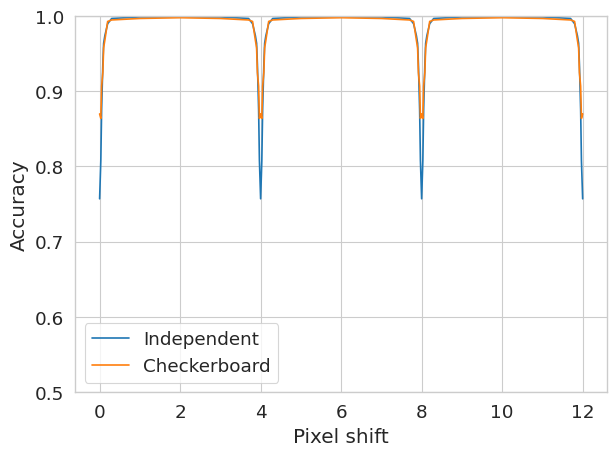

In [ ]:
import seaborn as sns

ps = np.array(pixel_shifts)
ps2 = np.flip(4 - ps)
ps = np.concatenate([ps, ps2])
ps = np.concatenate([ps, ps + 4, ps + 8])

nocb = np.array(accuracy[0])
nocb2 = np.flip(nocb)
nocb = np.concatenate([nocb, nocb2])
nocb = np.concatenate([nocb, nocb, nocb])

cb = np.array(accuracy[1])
cb2 = np.flip(cb)
cb = np.concatenate([cb, cb2])
cb = np.concatenate([cb, cb, cb])

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
plt.plot(ps, nocb, '-', label="Independent")
plt.plot(ps, cb, '-', label="Checkerboard")
plt.xlabel("Pixel shift")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

## Dim Star

An ambiguous detection (~80% detection prob) at the border and at the center.

First, we generate a true catalog.

In [ ]:
accuracy = [[], []]
pixel_shifts = (0.0, 0.03, 0.05, 0.08, 0.1, 0.13, 0.2, 0.3, 0.7, 1.0, 1.5, 2.0)

for pixel_shift in pixel_shifts:
    true_catalog, batch = gen_loc_shift_data(pixel_shift, flux=1.5)
    for use_cb in range(2):
        encoder.use_checkerboard = use_cb
        acc = 0
        for i in range(10):
            mode_cat, sample_cat = encoder.predict_step(batch, 0, 0).values()
            acc += (sample_cat["n_sources"][:, 9:11, 10].sum([1]) == 1).sum().item()
        accuracy[use_cb].append(acc / 1000)
        print(f"{use_cb}, {pixel_shift}: {acc}")


0, 0.0: 690
1, 0.0: 703
0, 0.03: 677
1, 0.03: 700
0, 0.05: 659
1, 0.05: 686
0, 0.08: 705
1, 0.08: 747
0, 0.1: 688
1, 0.1: 705
0, 0.13: 716
1, 0.13: 763
0, 0.2: 722
1, 0.2: 707
0, 0.3: 708
1, 0.3: 745
0, 0.7: 818
1, 0.7: 800
0, 1.0: 826
1, 1.0: 823
0, 1.5: 848
1, 1.5: 814
0, 2.0: 817
1, 2.0: 793


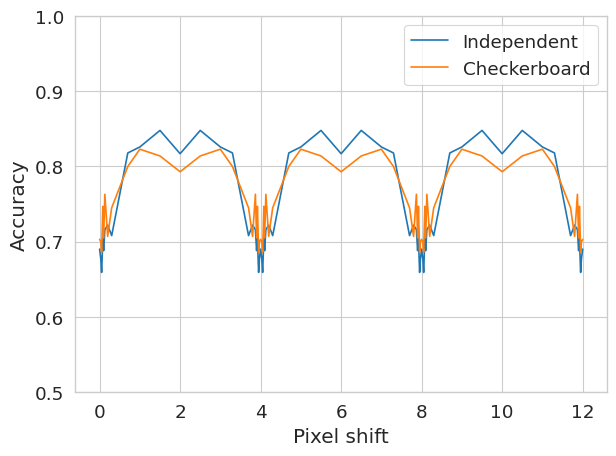

In [ ]:
import seaborn as sns

ps = np.array(pixel_shifts)
ps2 = np.flip(4 - ps)
ps = np.concatenate([ps, ps2])
ps = np.concatenate([ps, ps + 4, ps + 8])

nocb = np.array(accuracy[0])
nocb2 = np.flip(nocb)
nocb = np.concatenate([nocb, nocb2])
nocb = np.concatenate([nocb, nocb, nocb])

cb = np.array(accuracy[1])
cb2 = np.flip(cb)
cb = np.concatenate([cb, cb2])
cb = np.concatenate([cb, cb, cb])

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
plt.plot(ps, nocb, '-', label="Independent")
plt.plot(ps, cb, '-', label="Checkerboard")
plt.xlabel("Pixel shift")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

## Added galaxy, bright star

Now we render the images and backgrounds.

In [ ]:
true_catalog, batch = gen_loc_shift_data(0.0, add_galaxy=True)

In [ ]:
i = 0
loc1 = (true_catalog["locs"][i, 10, 10, 0] + 10 - 8) * 4 - 0.5

plt.imshow(batch["images"][i, 2, 32:48, 32:48].cpu().numpy(), cmap='viridis')
plt.grid(color='white', linewidth=1, linestyle='dotted')
plt.xticks(np.arange(4) * 4 + 3.5)
plt.yticks(np.arange(4) * 4 + 3.5)
plt.plot(loc1[1], loc1[0], 'ro', markersize=7)
plt.plot(5.5, 9.5, 'ro', markersize=7)
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both', length=0)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def marginal_detections(pred_marginal):  # noqa: WPS430
    est_cat = pred_marginal.sample(use_mode=False)
    est_cat["n_sources"][i, 10, 10] = 0  #only effects the conditional
    return est_cat

pred = encoder.infer(batch, marginal_detections)

on_prob = pred["marginal"].factors["on_prob"].probs[:, :, :, 1]
# Create a square heatmap using seaborn
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(on_prob[i, 8:12, 8:12].cpu().numpy(), annot=True, fmt=".2f", cmap="YlGnBu", linecolor='black', linewidths=0.5, cbar=False, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])

# Add black border to the bottom and right side
ax.hlines([4], *ax.get_xlim(), colors='black', linewidths=2)
ax.vlines([4], *ax.get_ylim(), colors='black', linewidths=2);

In [ ]:
from copy import deepcopy
on_prob = deepcopy(pred["black"].factors["on_prob"].probs[:, :, :, 1])
on_prob = torch.where(pred["white_history_mask"] > .5, on_prob, torch.nan * torch.ones_like(on_prob))
# Create a square heatmap using seaborn
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(on_prob[i, 8:12, 8:12].cpu().numpy(), annot=True, fmt=".2f", cmap="YlGnBu", vmax=1.0, linecolor='black', linewidths=0.5, cbar=False, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])

# Add black border to the bottom and right side
ax.hlines([4], *ax.get_xlim(), colors='black', linewidths=2)
ax.vlines([4], *ax.get_ylim(), colors='black', linewidths=2);

In [ ]:
def marginal_detections(pred_marginal):  # noqa: WPS430
    est_cat = pred_marginal.sample(use_mode=False)
    est_cat["n_sources"][i, 10, 10] = 1
    return est_cat

pred = encoder.infer(batch, marginal_detections)

from copy import deepcopy
on_prob = deepcopy(pred["black"].factors["on_prob"].probs[:, :, :, 1])
on_prob = torch.where(pred["white_history_mask"] > .5, on_prob, torch.nan * torch.ones_like(on_prob))
# Create a square heatmap using seaborn
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(on_prob[i, 8:12, 8:12].cpu().numpy(), annot=True, fmt=".2f", cmap="YlGnBu", linecolor='black', vmax=1.0, linewidths=0.5, cbar=False, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])

# Add black border to the bottom and right side
ax.hlines([4], *ax.get_xlim(), colors='black', linewidths=2)
ax.vlines([4], *ax.get_ylim(), colors='black', linewidths=2);